# Astrometry Response functions (Maps)

In [1]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

In [2]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):
v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

In [3]:
# unit vector in R3. 
#Given two angles, \theta E[0,pi] and \phi E[0,2pi], the next function returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

print(skyvec(2,3))
print(np.dot(skyvec(2,3),skyvec(2,3)))

[-0.90019763  0.12832006 -0.41614684]
1.0


## Uniform stars and fixed velocity

In [4]:
def vecdot(a,b): # (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=0)
    return dot
    
#a=[[0,1,2],[3,4,5],[6,7,8],[9,10,11]]
#b=[[0,1,1]]
#adotb=vecdot(a,b)
#print(adotb)

def hola(y):
    return np.where(y == 0, 0, y*np.log(y))
    
#print(hola(2))

def alpha(v,n1,n2):
    cos_zeta = vecdot(n1,n2)
    y = (1- cos_zeta)/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 6*n1v*(y-1)**3
    return num/den

def gamma(v,n1,n2):
    y = (1-vecdot(n1,n2))/2
    n1v = vecdot(n1,v)
    n2v = vecdot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*hola(y))
    den = 3*n1v*((y-1)**2)
    return num/den

I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

def GTanalytic_H1_00(v, p, q):
    y = (1-vecdot(p,q))/2 
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    alph = alpha(v,p,q)
    gamm = gamma(v,p,q)
    t1 = I_3[0,0] * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    t2 = np.outer(p, p)[0,0]*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[0,0]+np.outer(q, p)[0,0])
    t3 = np.outer(q, q)[0,0]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[0,0] + 2*gamm*np.outer(q, v)[0,0]
    return t1+t2+t3 

def GTanalytic_H1_11(v, p, q):
    y = (1-vecdot(p,q))/2 
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    alph = alpha(v,p,q)
    gamm = gamma(v,p,q)
    t1 = I_3[1,1] * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    t2 = np.outer(p, p)[1,1]*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[1,1]+np.outer(q, p)[1,1])
    t3 = np.outer(q, q)[1,1]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[1,1] + 2*gamm*np.outer(q, v)[1,1]
    return t1+t2+t3 

def GTanalytic_H1_22(v, p, q):
    y = (1-vecdot(p,q))/2 
    n1v = vecdot(p,v)
    n2v = vecdot(q,v)
    alph = alpha(v,p,q)
    gamm = gamma(v,p,q)
    t1 = I_3[2,2] * (alph*(2*y+1/(1-2*y) - 1) -2*gamm*n2v)
    t2 = np.outer(p, p)[2,2]*( alph/(2*y-1) + 2*gamm*n2v) +alph*(np.outer(p, q)[2,2]+np.outer(q, p)[2,2])
    t3 = np.outer(q, q)[2,2]*alph/(2*y-1) + 2*gamm*(2*y-1)*np.outer(p, v)[2,2] + 2*gamm*np.outer(q, v)[2,2]
    return t1+t2+t3 

[ 0 22 26]
1.3862943611198906


## Changing the color of the map according to a function

In [22]:
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)
print(unit_vector)
print(np.dot(unit_vector,unit_vector))

[-0.14563116  0.71537745 -0.68339349]
0.9999999999999999


dir shape: (3, 19200)
v shape: (3, 1)
vm shape: (3, 1)


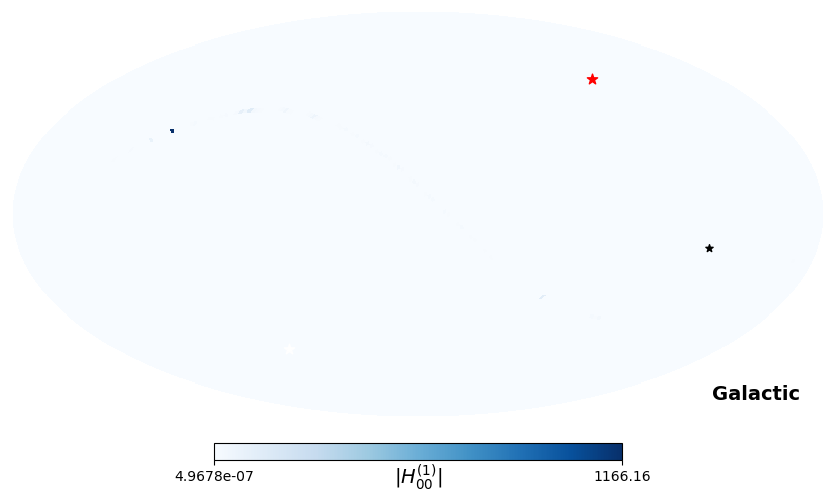

In [23]:
nside = 40 # 40 is a good number too. Kernel dies with 50 and larger numbers
npix = hp.nside2npix(nside)
theta, phi = hp.pix2ang(nside, np.arange(npix))
dir = skyvec(theta,phi) #.T#.reshape(npix,3)

v = skyvec(v_theta, v_phi).reshape(3,1)
#vn = skyvec(v_theta, v_phi).reshape(3,1) # Same direction as velocity 
#vn = skyvec(v_theta, v_phi+0.1).reshape(3,1) # Close to the velocity
#vn = -1.*np.array(v) # Opposite to the velocity
vn = unit_vector.reshape(3,1) # Random position
vs = -1.*np.array(v)
thetaVn, phiVn = hp.vec2ang(vn)
thetaVs, phiVs = hp.vec2ang(vs)


print('dir shape:',np.shape(dir))
print('v shape:',np.shape(v))
print('vm shape:',np.shape(vn))

Map_H1_00 = GTanalytic_H1_00(v,dir,vn)

hp.mollview(abs(Map_H1_00),title=r'',cmap='Blues',cbar=True,coord=['E','G'], unit=r'$|H^{(1)}_{00}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k',coord=['E','G']) 

#plt.savefig('H_00_VoppositeD.pdf',bbox_inches='tight')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/H_00_RandomStar.pdf')#,bbox_inches='tight')


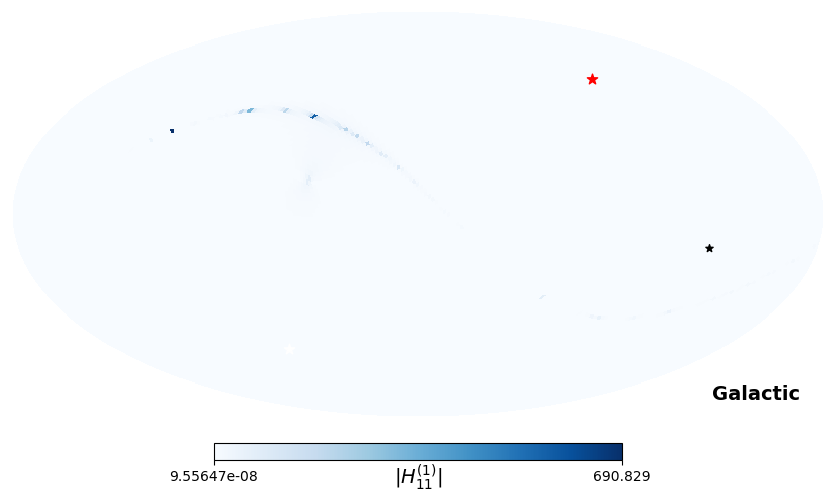

In [25]:
Map_H1_11 = GTanalytic_H1_11(v,dir,vn)
hp.mollview(abs(Map_H1_11),title=r'',cmap='Blues',cbar=True,coord=['E','G'], unit=r'$|H^{(1)}_{11}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k',coord=['E','G'])  

#plt.savefig('H_11_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/H_11_RandomStar.pdf')#,bbox_inches='tight')


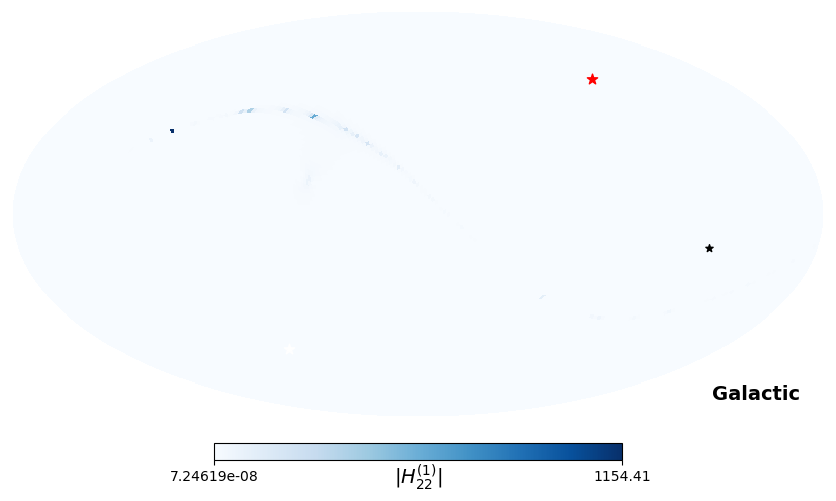

In [26]:
Map_H1_22 = GTanalytic_H1_22(v,dir,vn)
hp.mollview(abs(Map_H1_22),title=r'',cmap='Blues',cbar=True,coord=['E','G'], unit=r'$|H^{(1)}_{22}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k',coord=['E','G'])  

#plt.savefig('H_22_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/H_22_RandomStar.pdf')


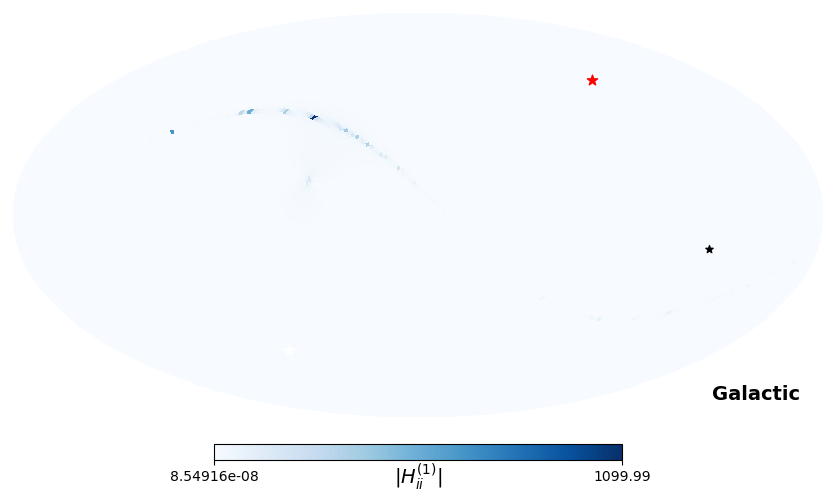

In [27]:
Trace_H1_ij = Map_H1_00 + Map_H1_11 + Map_H1_22

hp.mollview(abs(Trace_H1_ij),title=r'',cmap='Blues',cbar=True,coord=['E','G'], unit=r'$|H^{(1)}_{ii}|$')
hp.projscatter(v_theta,v_phi,marker='*',s=60,color='r',coord=['E','G'])
hp.projscatter(thetaVs,phiVs,marker='*',s=60,color='w',coord=['E','G'])
hp.projscatter(thetaVn,phiVn,marker='*',s=30,color='k',coord=['E','G'])  

#plt.savefig('H_ii_VoppositeD.pdf')
plt.savefig('/Users/marisol/Desktop/Astrometry_Codes/RandomStar_fixed/H_ii_RandomStar.pdf')
